<b> INPUT </b>
<br>
* .csv file with elution volume and absorbance information for sample.
* .csv file with elution volume and absorbance information for markers OR information about the markers that can be manually entered.

<b> OUTPUT </b>
<br>

* Chromatographic separation curves
    * Absorbance vs. Elution Volume for markers with molecular weight markings.
    * Absorbance vs. Elution Volume for sample protein with molecular weight markings.
* $K_{av}$ values

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import math
from sklearn.linear_model import LinearRegression

In [ ]:
#make the margins zero - untested
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [2]:
sample = pd.read_csv("E:\TKC_lab_stuff\chromatograpy_plots\Raw_data\Superdex 200\VS3_SUP200_047_clean.csv") #input for sample elution
markers = pd.read_csv("E:\TKC_lab_stuff\chromatograpy_plots\Raw_data\Superdex 200\Markers_Run_Sup_200_BETA_AMYL_BSA_CYTOC_001_clean.csv") #input for markers

In [3]:
# x axis will have flow rate * time = elution volume
# y axis will have absorbance values
s6_x = markers.Volume
s6_y = markers.Abs

[Text(0.5, 0, 'Elution vol(ml)'),
 Text(0, 0.5, 'Abs (AU)'),
 Text(0.5, 1.0, ' ')]

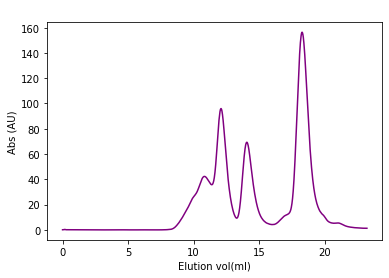

In [4]:
# Plotting the chromatographic separation curve for the markers
fig, ax = plt.subplots()
ax.plot(s6_x, s6_y, 'purple')
ax.set(xlabel='Elution vol(ml)', ylabel='Abs (AU)', title=' ')

In [5]:
#FILL IN MOL WEIGHTS HERE FOR THE MARKERS IN ASCENDING ORDER (in KDa)
#Mol weights for all peaks in markers
#marker_mol_wt = [2000, 669, 440, 158, 43, 29, 14, 6.5] 
marker_mol_wt = [223.8, 66.4, 14]

In [10]:
# finding peaks in the absorbance values
# The prominence of a peak measures how much a peak stands out from the surrounding baseline of the signal
peaks, _ = scipy.signal.find_peaks(s6_y, prominence=15)
#find_peaks returns the indices of peaks in absorbance values
peaks

array([16039, 18655, 24246], dtype=int64)

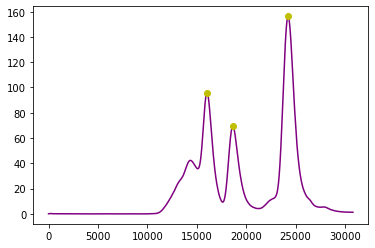

In [11]:
#visualising the peaks - change the prominence if there is more noise and peaks are not accurate
plt.plot(s6_y, 'purple')
plt.plot(peaks, s6_y[peaks], 'oy')

In [14]:
#Since find_peaks returns the indices, we use that y to get the elution volumes for the peaks
markers_vol = s6_x[peaks].to_numpy()
markers_vol

array([12.085835, 14.057002, 18.269846])

In [15]:
# DETAILS ABOUT THE COLUMN - FILL IN AS REQUIRED - Currently Superdex 200 
col_rad = 0.5
col_len = 30
void_vol = 8.3
total_vol = np.pi*(col_rad**2)*col_len #pi*0.5*0.5*30 depends on the column

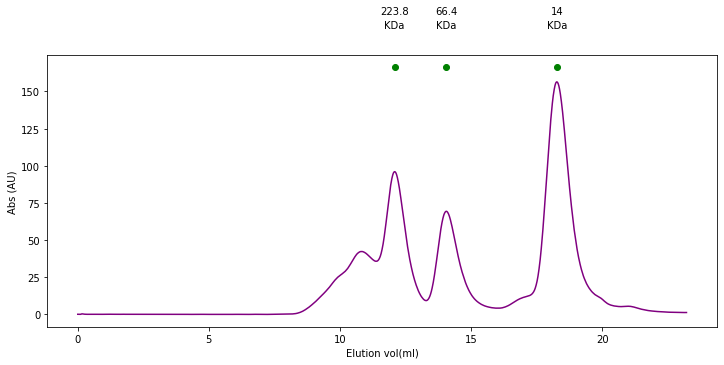

In [17]:
#adding the marker mol weights to the plot
# CHANGE PLOT ATTRIBUTES HERE

fig2, ax2 = plt.subplots(figsize=(12, 5)) # change the dimensions of the plot
trans = ax2.get_xaxis_transform() # x in data untis, y in axes fraction

# Change the value here to modify the distance between edge of the graph and circle
mw_abs = np.repeat(max(s6_y)*1.0625, len(marker_mol_wt))

ax2.plot(s6_x, s6_y, 'purple')
ax2.plot(markers_vol, mw_abs, 'og') 

ax2.set(xlabel='Elution vol(ml)', ylabel='Abs (AU)', title=' ') 

for i, txt in enumerate(marker_mol_wt):
    ax2.annotate(str(txt), (markers_vol[i], 1.15), xycoords=trans, horizontalalignment='center')
    ax2.annotate('KDa', (markers_vol[i], 1.1), xycoords=trans, horizontalalignment='center')
    ax2.annotate('(' + str(markers_vol[i].round(1)) +' ml)' , (markers_vol[i], 1.05), xycoords=trans, horizontalalignment='center')
    
fig2.savefig('marker_label.png', dpi = 540, bbox_inches = "tight")

### Calculating Kav values

In [11]:
#IN CASE, YOU WANT TO MANUALLY ENTER ELUTION VOLUME AND THE CORRESPONDING MOLECULAR WEIGHTS
#uncomment the following lines and enter the values with commas
#marker_mol_wt = []
#markers_vol = []

In [12]:
# markers
#calculating K_av values
Kav =[]
for i, mw in enumerate(marker_mol_wt):
    k = (markers_vol[i] - void_vol)/ (total_vol - void_vol)
    Kav.append([mw, k])

In [13]:
Kav

[[223.8, 0.2480571791032265],
 [66.4, 0.3772128674946567],
 [14, 0.6532487218417039]]

In [14]:
KAV = pd.DataFrame(Kav,columns=['Mol Wt (x1000)','K_av'])
KAV

,Mol Wt (x1000),K_av
0,223.8,0.248057
1,66.4,0.377213
2,14.0,0.653249


In [15]:
KAV['log M'] = np.log10(KAV['Mol Wt (x1000)'] *1000)
KAV['Mol Wt'] = KAV['Mol Wt (x1000)'] *1000
KAV

,Mol Wt (x1000),K_av,log M,Mol Wt
0,223.8,0.248057,5.349860,223800.0
1,66.4,0.377213,4.822168,66400.0
2,14.0,0.653249,4.146128,14000.0


<AxesSubplot:xlabel='log M', ylabel='K_av'>

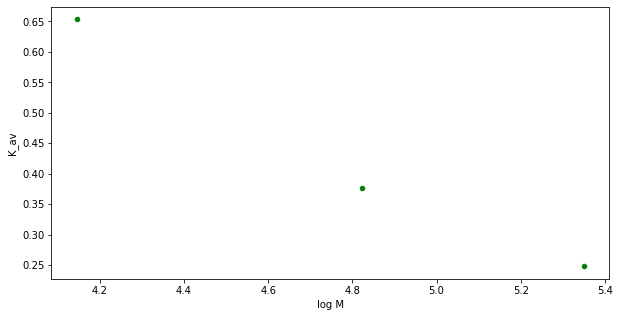

In [16]:
fig3, ax = plt.subplots(figsize=(10, 5))
KAV.plot(kind ='scatter', x='log M', y='K_av', ax = ax, color = 'green')


### Fitting straight line to $K_{av}$ and $\log{M}$

In [17]:
# Build the Model 
lreg = LinearRegression(fit_intercept=True)

#will change based on the column
X = KAV['log M']
Y = KAV['K_av']
# Convert the series data type to matrix (scikit requirement)
X_matrix = X.to_numpy().reshape(len(X),1)

model = lreg.fit(X_matrix,Y)

# use as y =mx +b to plot the fit
m = model.coef_[0]
b = model.intercept_ 

print("Coefficient - ",model.coef_[0])
print("Intercept - ", model.intercept_)

Y_fit = model.predict(X_matrix)

Coefficient -  -0.33990451533162386
Intercept -  2.0484415703681518


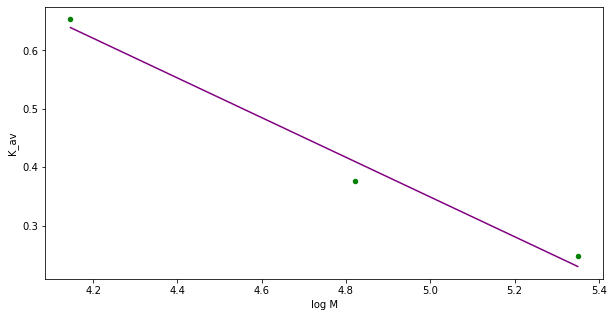

In [18]:
fig4, ax = plt.subplots(figsize=(10, 5))
KAV.plot(kind ='scatter', x='log M', y='K_av', ax = ax, color = 'green')
ax.plot(X, Y_fit, 'purple')


### Calculating Mol Weight of protein in sample

In [19]:
sam_x = sample['Volume']
sam_y = sample['Abs']


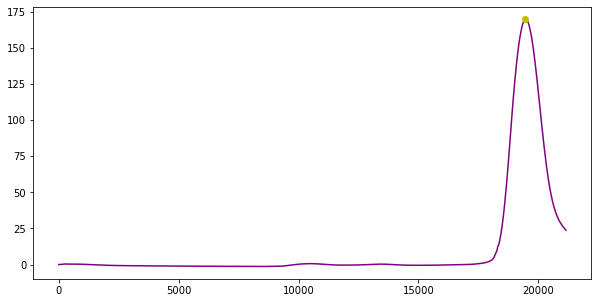

In [20]:
fig4, ax = plt.subplots(figsize=(10, 5))
ax.plot(sam_y, 'purple')
sam_peaks, _ = scipy.signal.find_peaks(sam_y, prominence=15) 
# The prominence of a peak measures how much a peak stands out from the surrounding baseline of the signal
# Might have to change the prominence if there is more noise in the signal
ax.plot(sam_peaks, sam_y[sam_peaks], 'oy')

In [21]:
sam_vol = sam_x[sam_peaks].to_numpy()
print(sam_vol)

[16.1649]


In [22]:
sam_kav =[]
for i, vol in enumerate(sam_vol):
    sam_k = (sam_vol[i] - void_vol)/ (total_vol - void_vol)
    sam_kav.append([vol, sam_k])

In [23]:
#Calculating Mol wt from K_av and elution volume
sam_KAV = pd.DataFrame(sam_kav,columns=['Elution Volume','Kav'])
sam_KAV['log M'] = (sam_KAV['Kav'] - b)/m
sam_KAV['Mol Wt'] = 10**sam_KAV['log M']
sam_KAV['Mol Wt'] = sam_KAV['Mol Wt'].round(2) 
sam_KAV['Mol Wt (KDa)'] = (sam_KAV['Mol Wt']/1000).round(1)
sam_KAV

,Elution Volume,Kav,log M,Mol Wt,Mol Wt (KDa)
0,16.1649,0.515328,4.510426,32391.1,32.4


### Plotting absorbance versus elution volume curves for sample

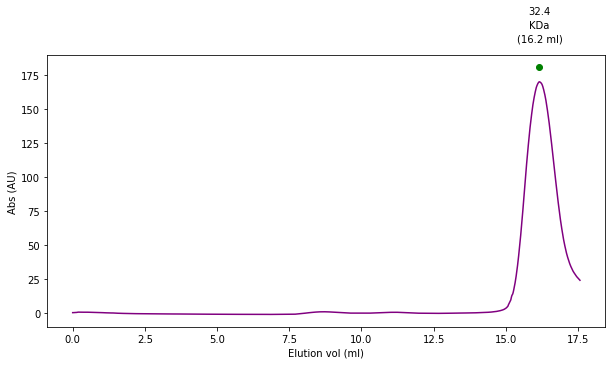

In [24]:
fig6, ax = plt.subplots(figsize=(10, 5))
trans6 = ax.get_xaxis_transform() # x in data untis, y in axes fraction
mw_abs = np.repeat(max(sam_y)*1.0625, len(sam_KAV))
ax.plot(sam_x, sam_y, 'purple')

ax.plot(sam_KAV['Elution Volume'], mw_abs, 'og')
ax.set(xlabel='Elution vol (ml)', ylabel='Abs (AU)', title=' ')

for i, txt in enumerate(sam_KAV['Mol Wt (KDa)']):
    ax.annotate(str(txt), (sam_KAV['Elution Volume'][i], 1.15), xycoords=trans6, horizontalalignment='center')
    ax.annotate('KDa', (sam_KAV['Elution Volume'][i], 1.1), xycoords=trans6, horizontalalignment='center')
    ax.annotate('('+ str(sam_KAV['Elution Volume'][i].round(1)) +' ml)', (sam_KAV['Elution Volume'][i], 1.05), xycoords=trans6, horizontalalignment='center')

fig6.savefig('sample_label.png', dpi = 540, bbox_inches = "tight")